In [1]:
import cv2
import sys
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [94]:
import cv2
import math
import os
import numpy as np
import scipy.signal
import shutil


def generating_kernel(parameter):
    kernel = np.array([0.25 - parameter / 2.0, 0.25, parameter,
                       0.25, 0.25 - parameter / 2.0])
    return np.outer(kernel, kernel)


def reduce_img(image):
    # per the instructions, use 0.4 for the kernel generation
    kernel = generating_kernel(0.4)

    # use convolve2d with the image and kernel sent in
    output = scipy.signal.convolve2d(image, kernel, 'same')

    # return every other line and row
    return output[:output.shape[0]:2, :output.shape[1]:2]


def expand(image):
    # per the instructions, use 0.4 for the kernel generation
    kernel = generating_kernel(0.4)

    # make a new array double the size, assign initial values
    output = np.zeros((image.shape[0] * 2, image.shape[1] * 2))
    output[:output.shape[0]:2, :output.shape[1]:2] = image

    # use convolve2d to fill in rest
    # multiply by 4 per instructions to scale back up
    output = scipy.signal.convolve2d(output, kernel, 'same') * 4
    return output


def gauss_pyramid(image, levels):
    output = [image]
    for level in range(levels):
        output.append(reduce_img(output[level]))

    return output


def lapl_pyramid(gauss_pyr):
    output = []
    # look over the lists, but ignore the last element since it cannot be
    # subtracted
    for image1, image2 in zip(gauss_pyr[:-1], gauss_pyr[1:]):
        # add in the subtracted difference
        # expand and bind the 2nd image based on the dimentions of the first
        output.append(
            image1 - expand(image2)[:image1.shape[0], :image1.shape[1]])

    # now add the last item back in
    output.append(gauss_pyr[-1])

    return output


def blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask):
    blended_pyr = []
    for lapl_white, lapl_black, gauss_mask in \
            zip(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask):
        blended_pyr.append(gauss_mask * lapl_white +
                           (1 - gauss_mask) * lapl_black)

    return blended_pyr


def collapse(pyramid):
    output = pyramid[-1]
    for image in reversed(pyramid[:-1]):
        output = image + expand(output)[:image.shape[0], :image.shape[1]]
    return output


def run_blend(black_image, white_image, mask):
    # Automatically figure out the size
    min_size = min(black_image.shape)
    # at least 16x16 at the highest level.
    depth = int(math.floor(math.log(min_size, 2))) - 4

    gauss_pyr_mask = gauss_pyramid(mask, depth)
    gauss_pyr_black = gauss_pyramid(black_image, depth)
    gauss_pyr_white = gauss_pyramid(white_image, depth)

    lapl_pyr_black = lapl_pyramid(gauss_pyr_black)
    lapl_pyr_white = lapl_pyramid(gauss_pyr_white)

    outpyr = blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask)
    outimg = collapse(outpyr)

    # blending sometimes results in slightly out of bound numbers.
    outimg[outimg < 0] = 0
    outimg[outimg > 255] = 255
    outimg = outimg.astype(np.uint8)

    return outimg


def get_images(sourcefolder):
    """Rewritten function to collect the three images from three folders."""
    filenames = os.listdir(sourcefolder)
    for photo in filenames:
        black_img = cv2.imread('../images/images_tilt/images/original/' + photo)
        white_img = cv2.imread('../images/blur/' + photo)
        mask_img = cv2.imread('../images/mask3/' + photo)

        if mask_img is None:
            print('Oops! There is no mask of image: ', photo)
            continue
        if white_img is None:
            print('Oops! There is no blurred version of image: ', photo)
            continue

        assert black_img.shape == white_img.shape, \
            "Error - the sizes of orignal and blur are not equal"

        assert black_img.shape == mask_img.shape, \
            "Error - the sizes of the original and the mask are not equal"

        print(photo)
        yield photo, white_img, black_img, mask_img

boat.jpg


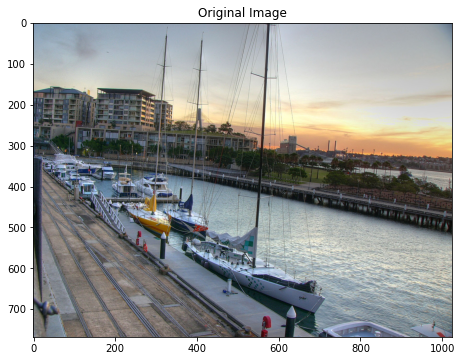

...applying blending


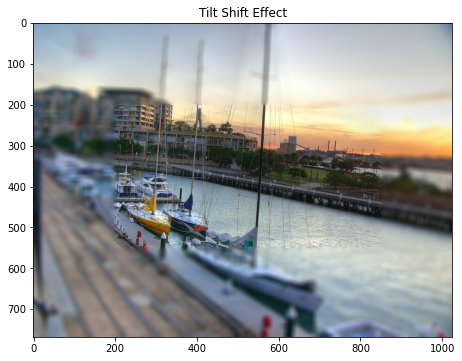

...[DONE]
city.jpg


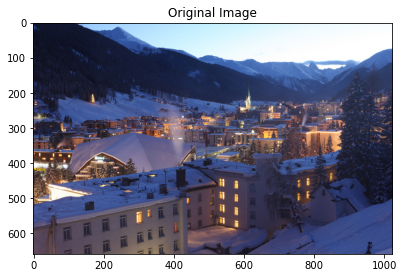

...applying blending


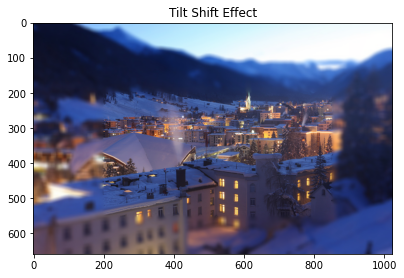

...[DONE]


In [95]:
def main():
    """Given the two images, blend them according to the mask."""

    sourcefolder = '../images/images_tilt/images/original'
    outfolder = '../images/o1'

    if os.path.isdir(outfolder):
        shutil.rmtree(outfolder)
    os.mkdir(outfolder)

    for photo, white_img, black_img, mask_img in get_images(sourcefolder):
        imshow("Original Image", black_img)
        print("...applying blending")
        black_img = black_img.astype(float)
        white_img = white_img.astype(float)
        mask_img = mask_img.astype(float) / 255

        out_layers = []
        for channel in range(3):
            outimg = run_blend(black_img[:, :, channel],
                               white_img[:, :, channel],
                               mask_img[:, :, channel])
            out_layers.append(outimg)

        outimg = cv2.merge(out_layers)
        cv2.imwrite(os.path.join(outfolder, photo), outimg)
        imshow("Tilt Shift Effect", outimg)
        print('...[DONE]')

if __name__ == "__main__":
    main()

In [11]:
#create blur folder containg blur images from original images

import cv2
import numpy as np
import os
import shutil


def make_more_vivid(image):
    """Modify the saturation and value of the image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue, saturation, value = cv2.split(hsv)

    saturation = np.array(saturation * 1.2, dtype=np.uint16)
    saturation = np.array(np.clip(saturation, 0, 255), dtype=np.uint8)

    value = np.array(value * 1.1, dtype=np.uint16)
    value = np.array(np.clip(value, 0, 255), dtype=np.uint8)

    return cv2.cvtColor(cv2.merge((hue, saturation, value)), cv2.COLOR_HSV2BGR)


def read_image(input_dir):
    """Read in an image and provide the image itself, name, and extension."""
    for photo in os.listdir(input_dir):
        name, ext = os.path.splitext(photo)
        image = cv2.imread(input_dir + '/' + photo)
        yield image, name, ext


def clean_folder(directory):
    """Clean out the given directory."""
    if os.path.isdir(directory):
        shutil.rmtree(directory)
    os.mkdir(directory)


def process(image):
    """Given an image process it using the process to replicate a lens blur."""
    image = make_more_vivid(image)
    image = cv2.bilateralFilter(image, 9, 150, 150)
    image = cv2.blur(image, (15, 15))

    return image


def main():
    """Given the images in a directory blur each of them."""
    input_dir = '../images/images_tilt/images/original'
    output_dir = '../images/blur'

    clean_folder(output_dir)
    for image, name, ext in read_image(input_dir):
        output = process(image)
        cv2.imwrite(output_dir + '/' + name + ext, output)
        print ('...[DONE]')

if __name__ == "__main__":
    main()

...[DONE]
...[DONE]


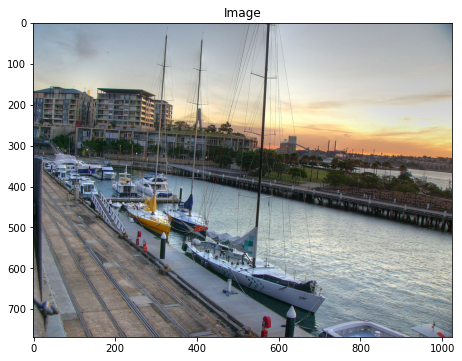

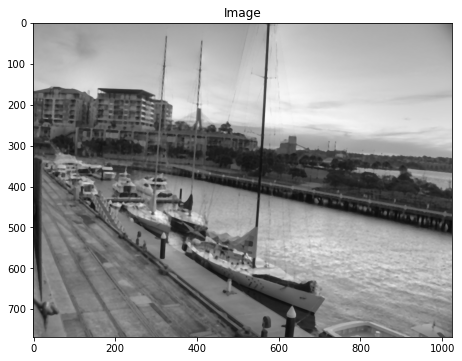

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\core\src\arithm.cpp:245: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'


In [44]:
input_dir = '../images/images_tilt/images/original'
for image, name, ext in read_image(input_dir):
        imshow('Image',image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.medianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 5)
        imshow('Image',gray)
        mask = np.full((img.shape[0], img.shape[1]), 0, dtype=np.uint8)
        fg = cv2.bitwise_or(img, img, mask=mask)
        mask = cv2.bitwise_not(mask)
        background = np.full(img.shape, 255, dtype=np.uint8)
        bk = cv2.bitwise_or(background, background, mask=mask)
        final = cv2.bitwise_or(fg, bk)
        imshow('Mask',final)
        imhow('Back',background)

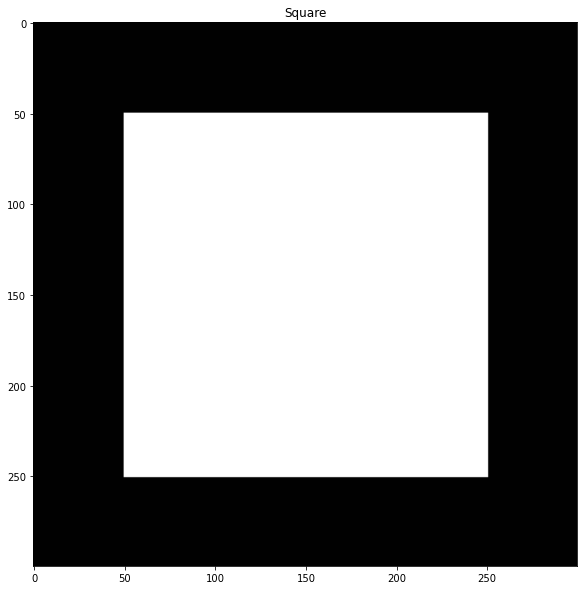

In [43]:
square = np.ones((300,300),np.uint8)
cv2.rectangle(square,(50,50),(250,250),(255,255),-1)
imshow('Square',square)

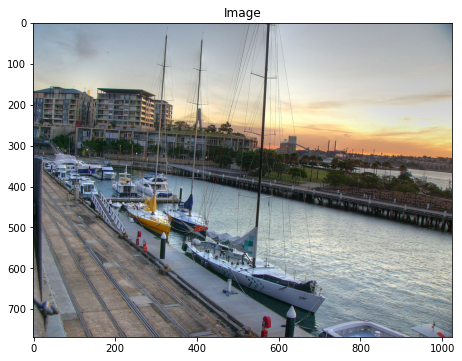

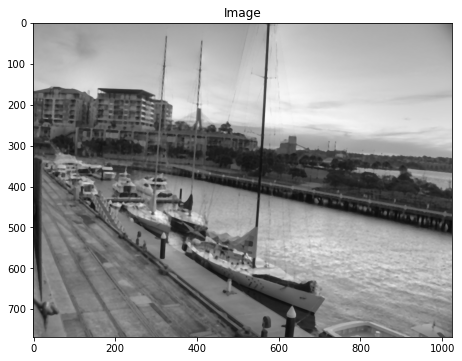

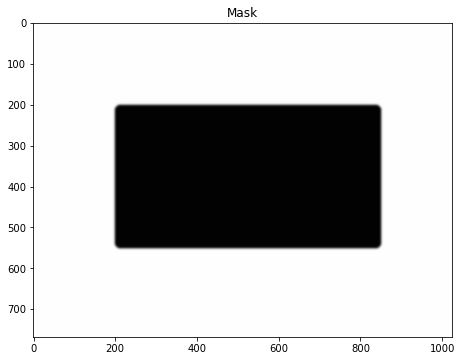

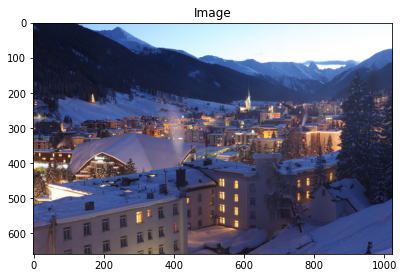

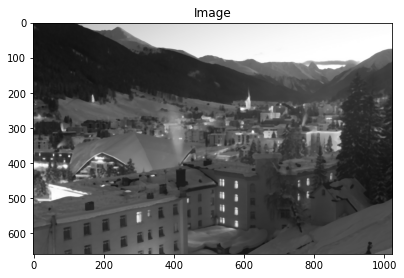

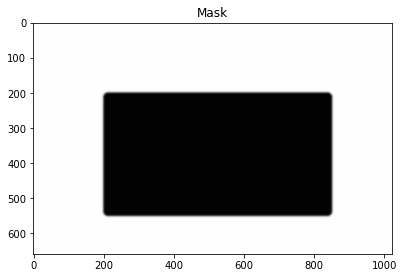

In [93]:
input_dir = '../images/images_tilt/images/original'
output_dir = '../images/mask3'
for image, name, ext in read_image(input_dir):
        imshow('Image',image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.medianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 5)
        imshow('Image',gray)
        mask = np.full((img.shape[0], img.shape[1]), 0, dtype=np.uint8)
        square = np.ones((img.shape[0], img.shape[1]),np.uint8)
        cv2.rectangle(square,(200,200),(850,550),(255,255),-1)
        mask = cv2.bitwise_or(mask,square)
        gauss = cv2.medianBlur(mask,19,0)
        gauss1 = cv2.GaussianBlur(gauss,(15,15),0)
        mask = cv2.bitwise_not(gauss1)
        imshow('Mask',mask)
        cv2.imwrite(output_dir + '/' + name + ext, mask)

In [49]:
gray.shape

(768, 1024)

In [51]:
square.shape

(768, 1024, 3)

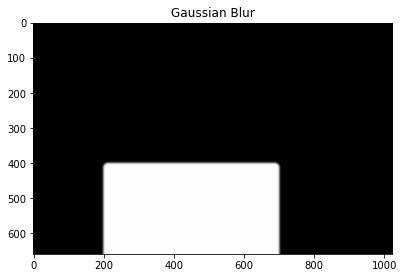

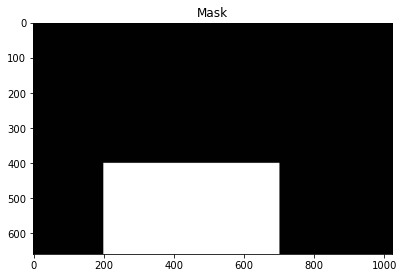

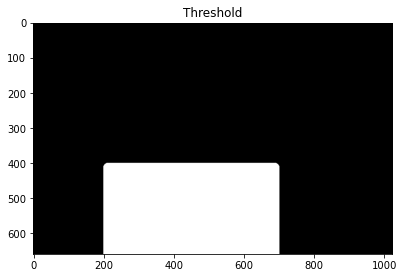

In [91]:
# masking the part to be in bokeh mode

mask = np.full((img.shape[0], img.shape[1]), 0, dtype=np.uint8)
square = np.ones((img.shape[0], img.shape[1]),np.uint8)
cv2.rectangle(square,(200,400),(700,800),(255,255),-1)
mask = cv2.bitwise_or(mask,square)
gauss = cv2.medianBlur(mask,19,0)
gauss1 = cv2.GaussianBlur(gauss,(15,15),0)
_,th1 = cv2.threshold(gauss,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow('Gaussian Blur',gauss1)
imshow('Mask',mask)
imshow('Threshold',th1)